# Regularization and Evaluation of Neural Networks

In [1]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.confusion import plot_confusion_matrix
    
%load_ext autoreload
%autoreload 2

## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [2]:
digits = load_digits()
X = digits.data.astype('float32')
y = digits.target.astype('float32')

y_binary = y % 2

In [3]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Epoch 1/50
180/180 [==============================] - 0s 603us/step - loss: 0.6440 - accuracy: 0.6583
Epoch 2/50
180/180 [==============================] - 0s 664us/step - loss: 0.2857 - accuracy: 0.8787
Epoch 3/50
180/180 [==============================] - 0s 533us/step - loss: 0.1819 - accuracy: 0.9243
Epoch 4/50
180/180 [==============================] - 0s 494us/step - loss: 0.1373 - accuracy: 0.9393
Epoch 5/50
180/180 [==============================] - 0s 608us/step - loss: 0.1110 - accuracy: 0.9527
Epoch 6/50
180/180 [==============================] - 0s 619us/step - loss: 0.0955 - accuracy: 0.9644
Epoch 7/50
180/180 [==============================] - 0s 556us/step - loss: 0.0831 - accuracy: 0.9661
Epoch 8/50
180/180 [==============================] - 0s 553us/step - loss: 0.0741 - accuracy: 0.9705
Epoch 9/50
180/180 [==============================] - 0s 494us/step - loss: 0.0670 - accuracy: 0.9738
Epoch 10/50
180/180 [==============================] - 0s 494us/step - loss: 0.058

In [4]:
type(X)

numpy.ndarray

In [5]:
type(y_binary)

numpy.ndarray

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling

**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [6]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

In [7]:
X_pure_train

array([[0.    , 0.    , 0.    , ..., 0.875 , 0.    , 0.    ],
       [0.    , 0.    , 0.125 , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.375 , ..., 0.1875, 0.    , 0.    ],
       [0.    , 0.    , 0.625 , ..., 0.8125, 1.    , 0.5   ],
       [0.    , 0.    , 0.25  , ..., 0.0625, 0.    , 0.    ]],
      dtype=float32)

### Sigmoid 

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [9]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 750us/step - loss: 0.7505 - accuracy: 0.4961
Epoch 2/10
12/12 [==============================] - 0s 667us/step - loss: 0.7409 - accuracy: 0.4961
Epoch 3/10
12/12 [==============================] - 0s 710us/step - loss: 0.7328 - accuracy: 0.4961
Epoch 4/10
12/12 [==============================] - 0s 708us/step - loss: 0.7261 - accuracy: 0.4961
Epoch 5/10
12/12 [==============================] - 0s 750us/step - loss: 0.7207 - accuracy: 0.4961
Epoch 6/10
12/12 [==============================] - 0s 625us/step - loss: 0.7162 - accuracy: 0.4961
Epoch 7/10
12/12 [==============================] - 0s 956us/step - loss: 0.7126 - accuracy: 0.4961
Epoch 8/10
12/12 [==============================] - 0s 750us/step - loss: 0.7097 - accuracy: 0.4961
Epoch 9/10
12/12 [==============================] - 0s 625us/step - loss: 0.7071 - accuracy: 0.4961
Epoch 10/10
12/12 [==============================] - 0s 875us/step - loss: 0.7050 - accuracy: 0.4961

We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [10]:
# dict
type(results)

tensorflow.python.keras.callbacks.History

In [11]:
results.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x1d4f2d90b80>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.750542402267456,
   0.7409108877182007,
   0.7327653169631958,
   0.7261422872543335,
   0.7206808924674988,
   0.7162248492240906,
   0.7126278877258301,
   0.7097132205963135,
   0.7071367502212524,
   0.7050380706787109],
  'accuracy': [0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [12]:
results.history

{'loss': [0.750542402267456,
  0.7409108877182007,
  0.7327653169631958,
  0.7261422872543335,
  0.7206808924674988,
  0.7162248492240906,
  0.7126278877258301,
  0.7097132205963135,
  0.7071367502212524,
  0.7050380706787109],
 'accuracy': [0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434,
  0.4960835576057434]}

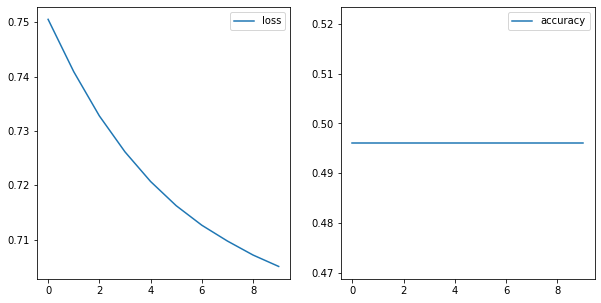

In [13]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

## Basic Model Tuning

### Increase Epochs

In [14]:
model = Sequential()
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs

results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=100, verbose=1)


Epoch 1/100
12/12 [==============================] - 0s 708us/step - loss: 0.7031 - accuracy: 0.4961
Epoch 2/100
12/12 [==============================] - 0s 667us/step - loss: 0.7013 - accuracy: 0.4961
Epoch 3/100
12/12 [==============================] - 0s 667us/step - loss: 0.6999 - accuracy: 0.4961
Epoch 4/100
12/12 [==============================] - 0s 877us/step - loss: 0.6988 - accuracy: 0.4961
Epoch 5/100
12/12 [==============================] - 0s 750us/step - loss: 0.6979 - accuracy: 0.4961
Epoch 6/100
12/12 [==============================] - 0s 625us/step - loss: 0.6972 - accuracy: 0.4961
Epoch 7/100
12/12 [==============================] - 0s 667us/step - loss: 0.6965 - accuracy: 0.4961
Epoch 8/100
12/12 [==============================] - 0s 667us/step - loss: 0.6960 - accuracy: 0.4961
Epoch 9/100
12/12 [==============================] - 0s 667us/step - loss: 0.6957 - accuracy: 0.4961
Epoch 10/100
12/12 [==============================] - 0s 917us/step - loss: 0.6954 - accura

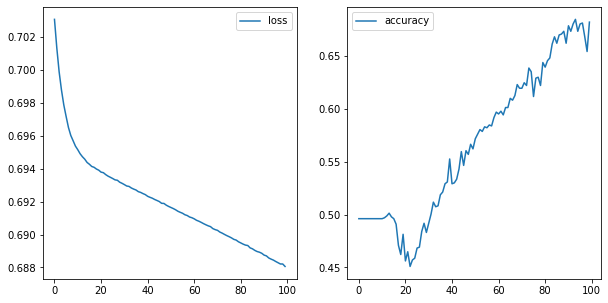

In [15]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Decrease Batch Size

In [16]:
model = Sequential()

model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# decrease batch size
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=10, verbose=1)

Epoch 1/10
115/115 [==============================] - 0s 596us/step - loss: 0.6949 - accuracy: 0.5039
Epoch 2/10
115/115 [==============================] - 0s 617us/step - loss: 0.6902 - accuracy: 0.5457
Epoch 3/10
115/115 [==============================] - 0s 735us/step - loss: 0.6889 - accuracy: 0.5805
Epoch 4/10
115/115 [==============================] - 0s 513us/step - loss: 0.6876 - accuracy: 0.6057
Epoch 5/10
115/115 [==============================] - 0s 565us/step - loss: 0.6864 - accuracy: 0.6188
Epoch 6/10
115/115 [==============================] - 0s 587us/step - loss: 0.6847 - accuracy: 0.6075
Epoch 7/10
115/115 [==============================] - 0s 496us/step - loss: 0.6840 - accuracy: 0.6371
Epoch 8/10
115/115 [==============================] - 0s 635us/step - loss: 0.6822 - accuracy: 0.6806
Epoch 9/10
115/115 [==============================] - 0s 717us/step - loss: 0.6812 - accuracy: 0.6449
Epoch 10/10
115/115 [==============================] - 0s 535us/step - loss: 0.679

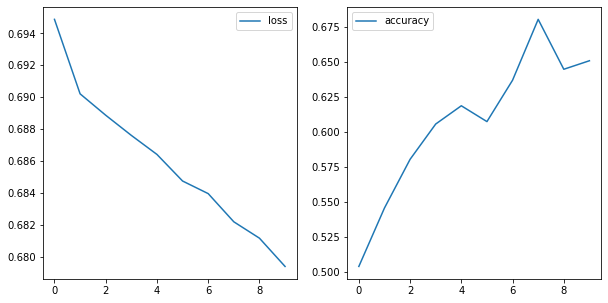

In [17]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Both

In [24]:
model = Sequential()

model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# increase epochs decrease batch size
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=10, verbose=1)

Epoch 1/100
115/115 [==============================] - 0s 630us/step - loss: 0.7112 - accuracy: 0.4961
Epoch 2/100
115/115 [==============================] - 0s 713us/step - loss: 0.6971 - accuracy: 0.4952
Epoch 3/100
115/115 [==============================] - 0s 657us/step - loss: 0.6948 - accuracy: 0.4569
Epoch 4/100
115/115 [==============================] - 0s 743us/step - loss: 0.6942 - accuracy: 0.4761
Epoch 5/100
115/115 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.50 - 0s 774us/step - loss: 0.6937 - accuracy: 0.4952
Epoch 6/100
115/115 [==============================] - 0s 952us/step - loss: 0.6934 - accuracy: 0.5222
Epoch 7/100
115/115 [==============================] - 0s 735us/step - loss: 0.6933 - accuracy: 0.4848
Epoch 8/100
115/115 [==============================] - 0s 822us/step - loss: 0.6928 - accuracy: 0.5222
Epoch 9/100
115/115 [==============================] - 0s 783us/step - loss: 0.6927 - accuracy: 0.5170
Epoch 10/100
115/115 [=========

115/115 [==============================] - 0s 843us/step - loss: 0.4637 - accuracy: 0.8503
Epoch 80/100
115/115 [==============================] - 0s 835us/step - loss: 0.4542 - accuracy: 0.8547
Epoch 81/100
115/115 [==============================] - 0s 1ms/step - loss: 0.4452 - accuracy: 0.8529
Epoch 82/100
115/115 [==============================] - 0s 1ms/step - loss: 0.4360 - accuracy: 0.8607
Epoch 83/100
115/115 [==============================] - 0s 804us/step - loss: 0.4275 - accuracy: 0.8642
Epoch 84/100
115/115 [==============================] - 0s 678us/step - loss: 0.4192 - accuracy: 0.8581
Epoch 85/100
115/115 [==============================] - 0s 743us/step - loss: 0.4112 - accuracy: 0.8625
Epoch 86/100
115/115 [==============================] - 0s 657us/step - loss: 0.4030 - accuracy: 0.8599
Epoch 87/100
115/115 [==============================] - 0s 713us/step - loss: 0.3957 - accuracy: 0.8703
Epoch 88/100
115/115 [==============================] - 0s 713us/step - loss: 0.3

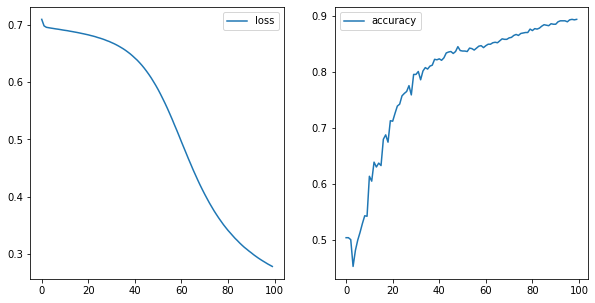

In [19]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Use Relu

In [20]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs, decrease batchsize


results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 583us/step - loss: 0.8116 - accuracy: 0.5039
Epoch 2/10
12/12 [==============================] - 0s 958us/step - loss: 0.7526 - accuracy: 0.5039
Epoch 3/10
12/12 [==============================] - 0s 708us/step - loss: 0.7187 - accuracy: 0.5205
Epoch 4/10
12/12 [==============================] - 0s 792us/step - loss: 0.6977 - accuracy: 0.5352
Epoch 5/10
12/12 [==============================] - 0s 878us/step - loss: 0.6831 - accuracy: 0.5840
Epoch 6/10
12/12 [==============================] - 0s 958us/step - loss: 0.6725 - accuracy: 0.5970
Epoch 7/10
12/12 [==============================] - 0s 1000us/step - loss: 0.6632 - accuracy: 0.6214
Epoch 8/10
12/12 [==============================] - 0s 791us/step - loss: 0.6547 - accuracy: 0.6397
Epoch 9/10
12/12 [==============================] - 0s 833us/step - loss: 0.6468 - accuracy: 0.6597
Epoch 10/10
12/12 [==============================] - 0s 544us/step - loss: 0.6391 - accuracy: 0.675

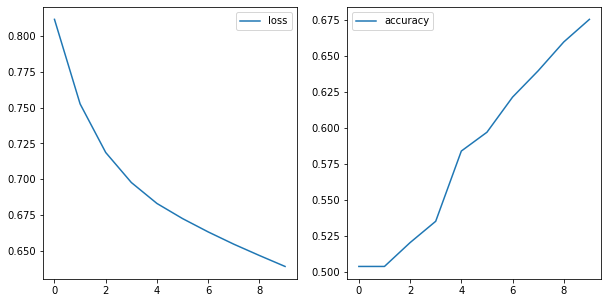

In [21]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### All of it (epochs, batch, relu)

In [22]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs


results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=10, verbose=1)

Epoch 1/100
115/115 [==============================] - 0s 617us/step - loss: 0.6808 - accuracy: 0.5544
Epoch 2/100
115/115 [==============================] - 0s 639us/step - loss: 0.6246 - accuracy: 0.6701
Epoch 3/100
115/115 [==============================] - 0s 617us/step - loss: 0.5753 - accuracy: 0.7659
Epoch 4/100
115/115 [==============================] - 0s 600us/step - loss: 0.5305 - accuracy: 0.8068
Epoch 5/100
115/115 [==============================] - 0s 478us/step - loss: 0.4906 - accuracy: 0.8355
Epoch 6/100
115/115 [==============================] - 0s 526us/step - loss: 0.4561 - accuracy: 0.8512
Epoch 7/100
115/115 [==============================] - 0s 504us/step - loss: 0.4254 - accuracy: 0.8599
Epoch 8/100
115/115 [==============================] - 0s 591us/step - loss: 0.3958 - accuracy: 0.8634
Epoch 9/100
115/115 [==============================] - 0s 665us/step - loss: 0.3686 - accuracy: 0.8755
Epoch 10/100
115/115 [==============================] - 0s 622us/step - l

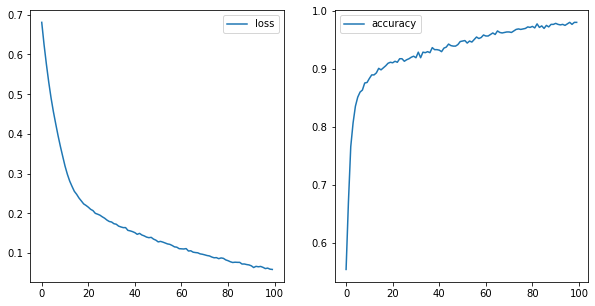

In [23]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Side note: learning rate

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
115/115 [==============================] - 0s 696us/step - loss: 0.6395 - accuracy: 0.7023
Epoch 2/30
115/115 [==============================] - 0s 648us/step - loss: 0.5768 - accuracy: 0.7963
Epoch 3/30
115/115 [==============================] - 0s 665us/step - loss: 0.4978 - accuracy: 0.8372
Epoch 4/30
115/115 [==============================] - 0s 557us/step - loss: 0.4185 - accuracy: 0.8538
Epoch 5/30
115/115 [==============================] - 0s 743us/step - loss: 0.3584 - accuracy: 0.8695
Epoch 6/30
115/115 [==============================] - 0s 730us/step - loss: 0.3185 - accuracy: 0.8816
Epoch 7/30
115/115 [==============================] - 0s 778us/step - loss: 0.2895 - accuracy: 0.8895
Epoch 8/30
115/115 [==============================] - 0s 696us/step - loss: 0.2706 - accuracy: 0.8903
Epoch 9/30
115/115 [==============================] - 0s 804us/step - loss: 0.2553 - accuracy: 0.8999
Epoch 10/30
115/115 [==============================] - 0s 857us/step - loss: 0.243

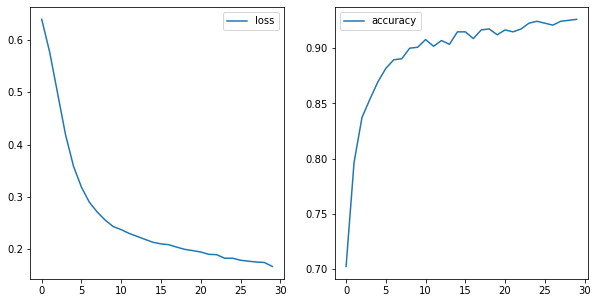

In [30]:
model = Sequential()

sgd = SGD()


model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();


### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

In [37]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
# model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE


results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, 
                    batch_size=10, 
                    verbose=1,
                    validation_data=(X_val, y_val))

Epoch 1/30
115/115 [==============================] - 0s 2ms/step - loss: 0.6582 - accuracy: 0.6571 - val_loss: 0.5380 - val_accuracy: 0.8194
Epoch 2/30
115/115 [==============================] - 0s 883us/step - loss: 0.4289 - accuracy: 0.8425 - val_loss: 0.3533 - val_accuracy: 0.8542
Epoch 3/30
115/115 [==============================] - 0s 1000us/step - loss: 0.3153 - accuracy: 0.8755 - val_loss: 0.3093 - val_accuracy: 0.8646
Epoch 4/30
115/115 [==============================] - 0s 1ms/step - loss: 0.2672 - accuracy: 0.8912 - val_loss: 0.2535 - val_accuracy: 0.8889
Epoch 5/30
115/115 [==============================] - 0s 1ms/step - loss: 0.2398 - accuracy: 0.9025 - val_loss: 0.2681 - val_accuracy: 0.8854
Epoch 6/30
115/115 [==============================] - 0s 1ms/step - loss: 0.2210 - accuracy: 0.9104 - val_loss: 0.2374 - val_accuracy: 0.9062
Epoch 7/30
115/115 [==============================] - 0s 983us/step - loss: 0.2117 - accuracy: 0.9130 - val_loss: 0.2069 - val_accuracy: 0.9236

In [38]:
results.history

{'loss': [0.6582072377204895,
  0.42885661125183105,
  0.31530553102493286,
  0.2671569287776947,
  0.23978975415229797,
  0.22101923823356628,
  0.21173302829265594,
  0.19739209115505219,
  0.18046657741069794,
  0.16910812258720398,
  0.16368572413921356,
  0.1515119969844818,
  0.13960647583007812,
  0.13042683899402618,
  0.12135207653045654,
  0.11361412703990936,
  0.10805061459541321,
  0.10141109675168991,
  0.09497219324111938,
  0.09195216745138168,
  0.08532789349555969,
  0.08533570170402527,
  0.08014397323131561,
  0.07481054961681366,
  0.07118075340986252,
  0.06816211342811584,
  0.0658666118979454,
  0.06078367307782173,
  0.058574289083480835,
  0.06138451397418976],
 'accuracy': [0.6570931077003479,
  0.842471718788147,
  0.8755439519882202,
  0.8912097215652466,
  0.902523934841156,
  0.9103568196296692,
  0.9129678010940552,
  0.9190600514411926,
  0.9242819547653198,
  0.9268929362297058,
  0.9295039176940918,
  0.9355961680412292,
  0.9390774369239807,
  0.9434

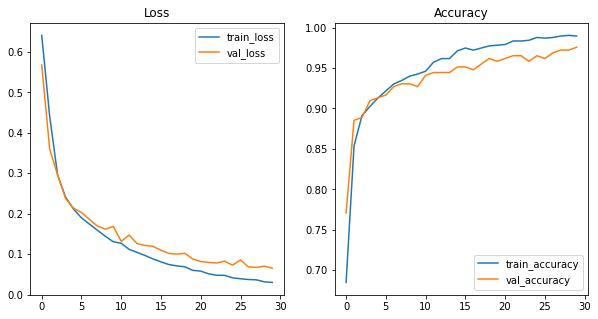

In [33]:
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [39]:
results.history['val_accuracy'][-1]

0.9548611044883728

In [40]:
results.history['accuracy'][-1]

0.9799826145172119

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [41]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001D4F6261E80> does not.

In [42]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
model.fit()

In [44]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=10,
                                          batch_size=32,
                                          verbose=2)

In [45]:
type(keras_model)

tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier

In [46]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

Epoch 1/10
29/29 - 0s - loss: 0.6806 - accuracy: 0.4929
Epoch 2/10
29/29 - 0s - loss: 0.6464 - accuracy: 0.4951
Epoch 3/10
29/29 - 0s - loss: 0.6099 - accuracy: 0.5332
Epoch 4/10
29/29 - 0s - loss: 0.5695 - accuracy: 0.6355
Epoch 5/10
29/29 - 0s - loss: 0.5317 - accuracy: 0.7367
Epoch 6/10
29/29 - 0s - loss: 0.4995 - accuracy: 0.8357
Epoch 7/10
29/29 - 0s - loss: 0.4731 - accuracy: 0.8585
Epoch 8/10
29/29 - 0s - loss: 0.4537 - accuracy: 0.8760
Epoch 9/10
29/29 - 0s - loss: 0.4351 - accuracy: 0.8857
Epoch 10/10
29/29 - 0s - loss: 0.4190 - accuracy: 0.8912
8/8 - 0s - loss: 0.4035 - accuracy: 0.8783
Epoch 1/10
29/29 - 0s - loss: 0.6276 - accuracy: 0.6746
Epoch 2/10
29/29 - 0s - loss: 0.5473 - accuracy: 0.7682
Epoch 3/10
29/29 - 0s - loss: 0.4712 - accuracy: 0.8292
Epoch 4/10
29/29 - 0s - loss: 0.4040 - accuracy: 0.8433
Epoch 5/10
29/29 - 0s - loss: 0.3472 - accuracy: 0.8618
Epoch 6/10
29/29 - 0s - loss: 0.3020 - accuracy: 0.8738
Epoch 7/10
29/29 - 0s - loss: 0.2678 - accuracy: 0.8934
Epoc

array([0.87826085, 0.9217391 , 0.90434784, 0.92608696, 0.88646287])

## [Regularization](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer)

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

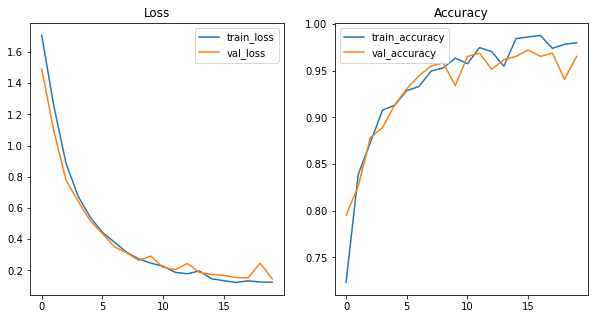

In [47]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu',kernel_regularizer=l2(l=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

Adding L2 to multiple layers:

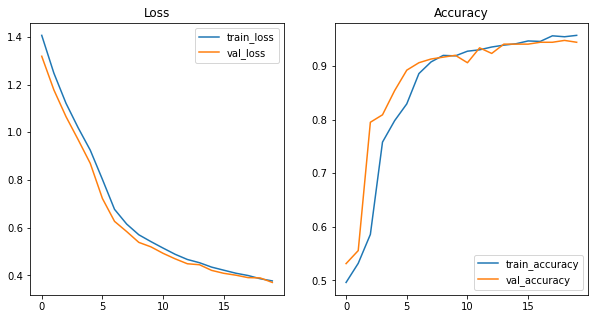

In [48]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

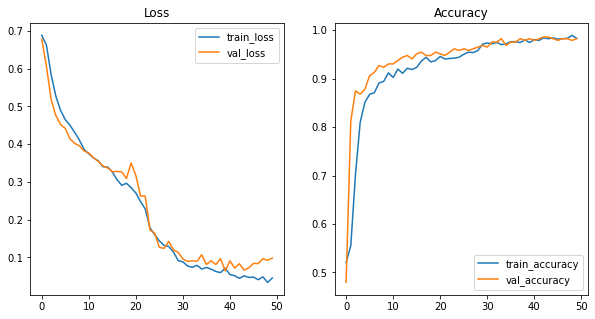

In [52]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(12, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [53]:
results.history['val_accuracy'][-1]

0.9826388955116272

In [54]:
results.history['accuracy'][-1]

0.9834638833999634

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

Epoch 00011: early stopping


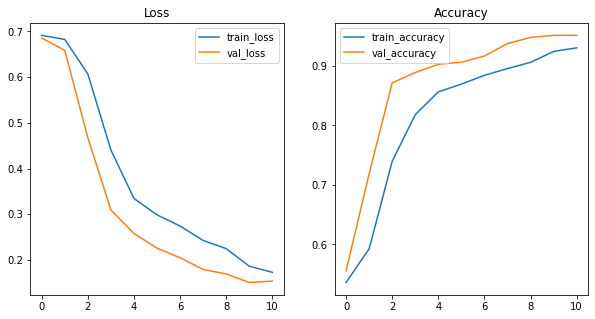

In [57]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=40, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 00086: early stopping


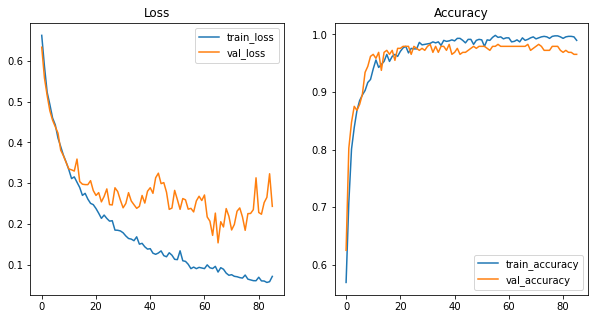

In [63]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min',
                           patience=20)

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=100, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [64]:
results.history['val_accuracy'][-1]

0.9652777910232544

In [65]:
results.history['accuracy'][-1]

0.9895561337471008

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [66]:
digits = load_digits()
X = digits.data
y = digits.target

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [68]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [69]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [82]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=64))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 0s 2ms/step - loss: 2.2229 - accuracy: 0.2185 - val_loss: 2.1282 - val_accuracy: 0.3194
Epoch 2/50
115/115 [==============================] - 0s 1ms/step - loss: 1.8555 - accuracy: 0.4343 - val_loss: 1.6145 - val_accuracy: 0.4792
Epoch 3/50
115/115 [==============================] - 0s 1ms/step - loss: 1.2049 - accuracy: 0.5927 - val_loss: 1.0262 - val_accuracy: 0.6597
Epoch 4/50
115/115 [==============================] - 0s 1ms/step - loss: 0.7275 - accuracy: 0.8129 - val_loss: 0.6718 - val_accuracy: 0.8125
Epoch 5/50
115/115 [==============================] - 0s 2ms/step - loss: 0.5054 - accuracy: 0.8686 - val_loss: 0.5321 - val_accuracy: 0.8403
Epoch 6/50
115/115 [==============================] - 0s 1ms/step - loss: 0.3969 - accuracy: 0.8938 - val_loss: 0.4319 - val_accuracy: 0.8611
Epoch 7/50
115/115 [==============================] - 0s 978us/step - loss: 0.3372 - accuracy: 0.9138 - val_loss: 0.3961 - val_accuracy: 0.8958
Epoc

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [83]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

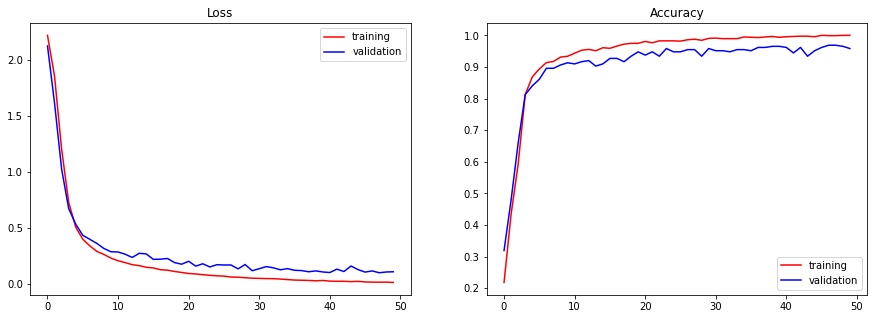

In [84]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)

ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [85]:
results.history['val_accuracy'][-1]

0.9583333134651184

In [86]:
results.history['accuracy'][-1]

1.0

In [76]:
X[0].reshape((8,8))

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.
